In [4]:
#Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#For showing plots directly in the notebook run the command below
%matplotlib inline

# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages

# Import seaborn library
import seaborn as sns

# Hide ipykernel warnings
import warnings
warnings.filterwarnings('ignore')

# Set pandas to display all columns
pd.set_option('display.max_columns', None)



In [5]:
# Read from csv file into a data frame
df = pd.read_csv('PostDQP.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [6]:
df.dtypes

ObjectID                   int64
Damage                    object
StreetType                object
ZipCode                  float64
CALFIREUnit               object
County                    object
IncidentStartDate         object
StructureType             object
RoofConstruction          object
VentScreen                object
ExteriorSiding            object
WindowPane                object
Deck/PorchOnGrade         object
Deck/PorchElevated        object
AssessedImprovedValue    float64
YearBuilt                  int64
Latitude                 float64
Longitude                float64
dtype: object

In [7]:
# Convert all object columns to category
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')

# Strip the '.' and everything to the right for 'ZipCode'
df['ZipCode'] = df['ZipCode'].astype(str).str.split('.').str[0]

# Convert 'ZipCode' back to categorical
df['ZipCode'] = df['ZipCode'].astype("category")

df['IncidentStartDate'] = pd.to_datetime(df['IncidentStartDate'])

In [8]:
df.dtypes

ObjectID                    int64
Damage                   category
StreetType               category
ZipCode                  category
CALFIREUnit              category
County                   category
IncidentStartDate        category
StructureType            category
RoofConstruction         category
VentScreen               category
ExteriorSiding           category
WindowPane               category
Deck/PorchOnGrade        category
Deck/PorchElevated       category
AssessedImprovedValue     float64
YearBuilt                   int64
Latitude                  float64
Longitude                 float64
dtype: object

(3). [15] Exploring relationships between feature pairs:

    - Choose a subset of features you find promising and plot pairwise feature interactions (e.g., 
    continuous-continuous feature plot or continuous-categorical plots or correlation plots). 
    Explain your choices.
    - Discuss your findings from the plots above. Do you find any features or feature combinations that are 
    indicative of the target outcome? Explain in plain words (a short paragraph) the story of your
    findings so far.

#### Chosen Features
- Pair 1: AgeofStructure (Continuous) vs. AssessedImprovedValue (Continuous)
    - There might be a relationship between the assessed improvement value of a property and the year it was built
    - Older properties might have lower assessed improvement valuations due to depreciation of the property
    - Properties that are more vulnerable to wildfire damage might have lower assessed improvement valuations
    - High values for property improvements may indicate properties that are more carefully maintained
    - AgeofStructure will be derived from YearBuilt and current year
- Pair 2: RoofConstruction (Cateogorical) vs. ExteriorSiding (Categorical)
    - Determine whether there are common combinations or patterns between the materials used for a building's roof and its exterior siding. Certain roof constructions might be more frequently paired with a specific siding type due to factors such as:
        - Building style/era
        - Climate
        - Cost and availability
        - Local building codes

In [9]:
# Encode feature YearBuilt to get the age of the structure
df['AgeofStructure'] = pd.to_datetime('now').year - df['YearBuilt']

#### Plot 1: AssessedImprovedValue vs. AgeofStructure (Continuous-Continuous Pairwise Scatter Plot)

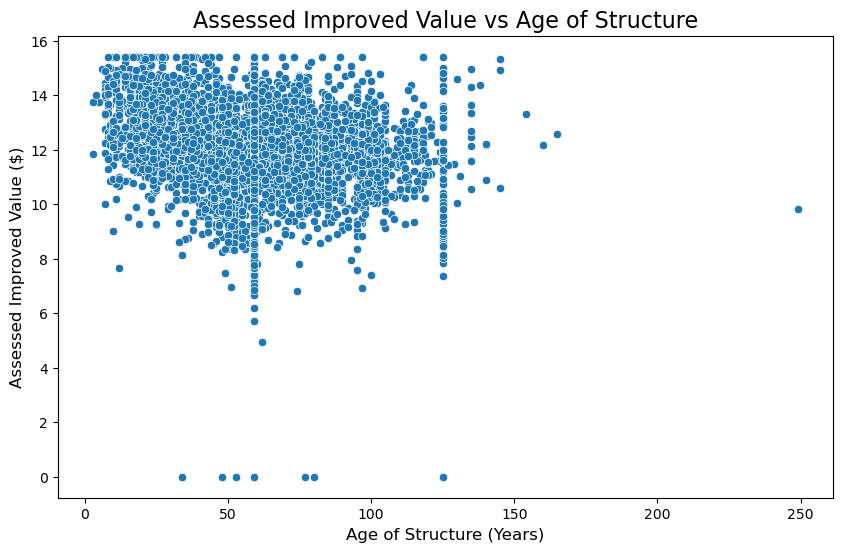

In [10]:
# Plot AssessedImprovedValue vs. AgeofStructure
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AgeofStructure', y='AssessedImprovedValue', data=df)

# Adding titles and labels
plt.title('Assessed Improved Value vs Age of Structure', fontsize=16)
plt.xlabel('Age of Structure (Years)', fontsize=12)
plt.ylabel('Assessed Improved Value ($)', fontsize=12)

# Show plot
plt.show()

##### **Observations:**
- The relationship between property improvement value and age of structure is not linear. The points are dispered across the plot rather than forming a tight line or curve

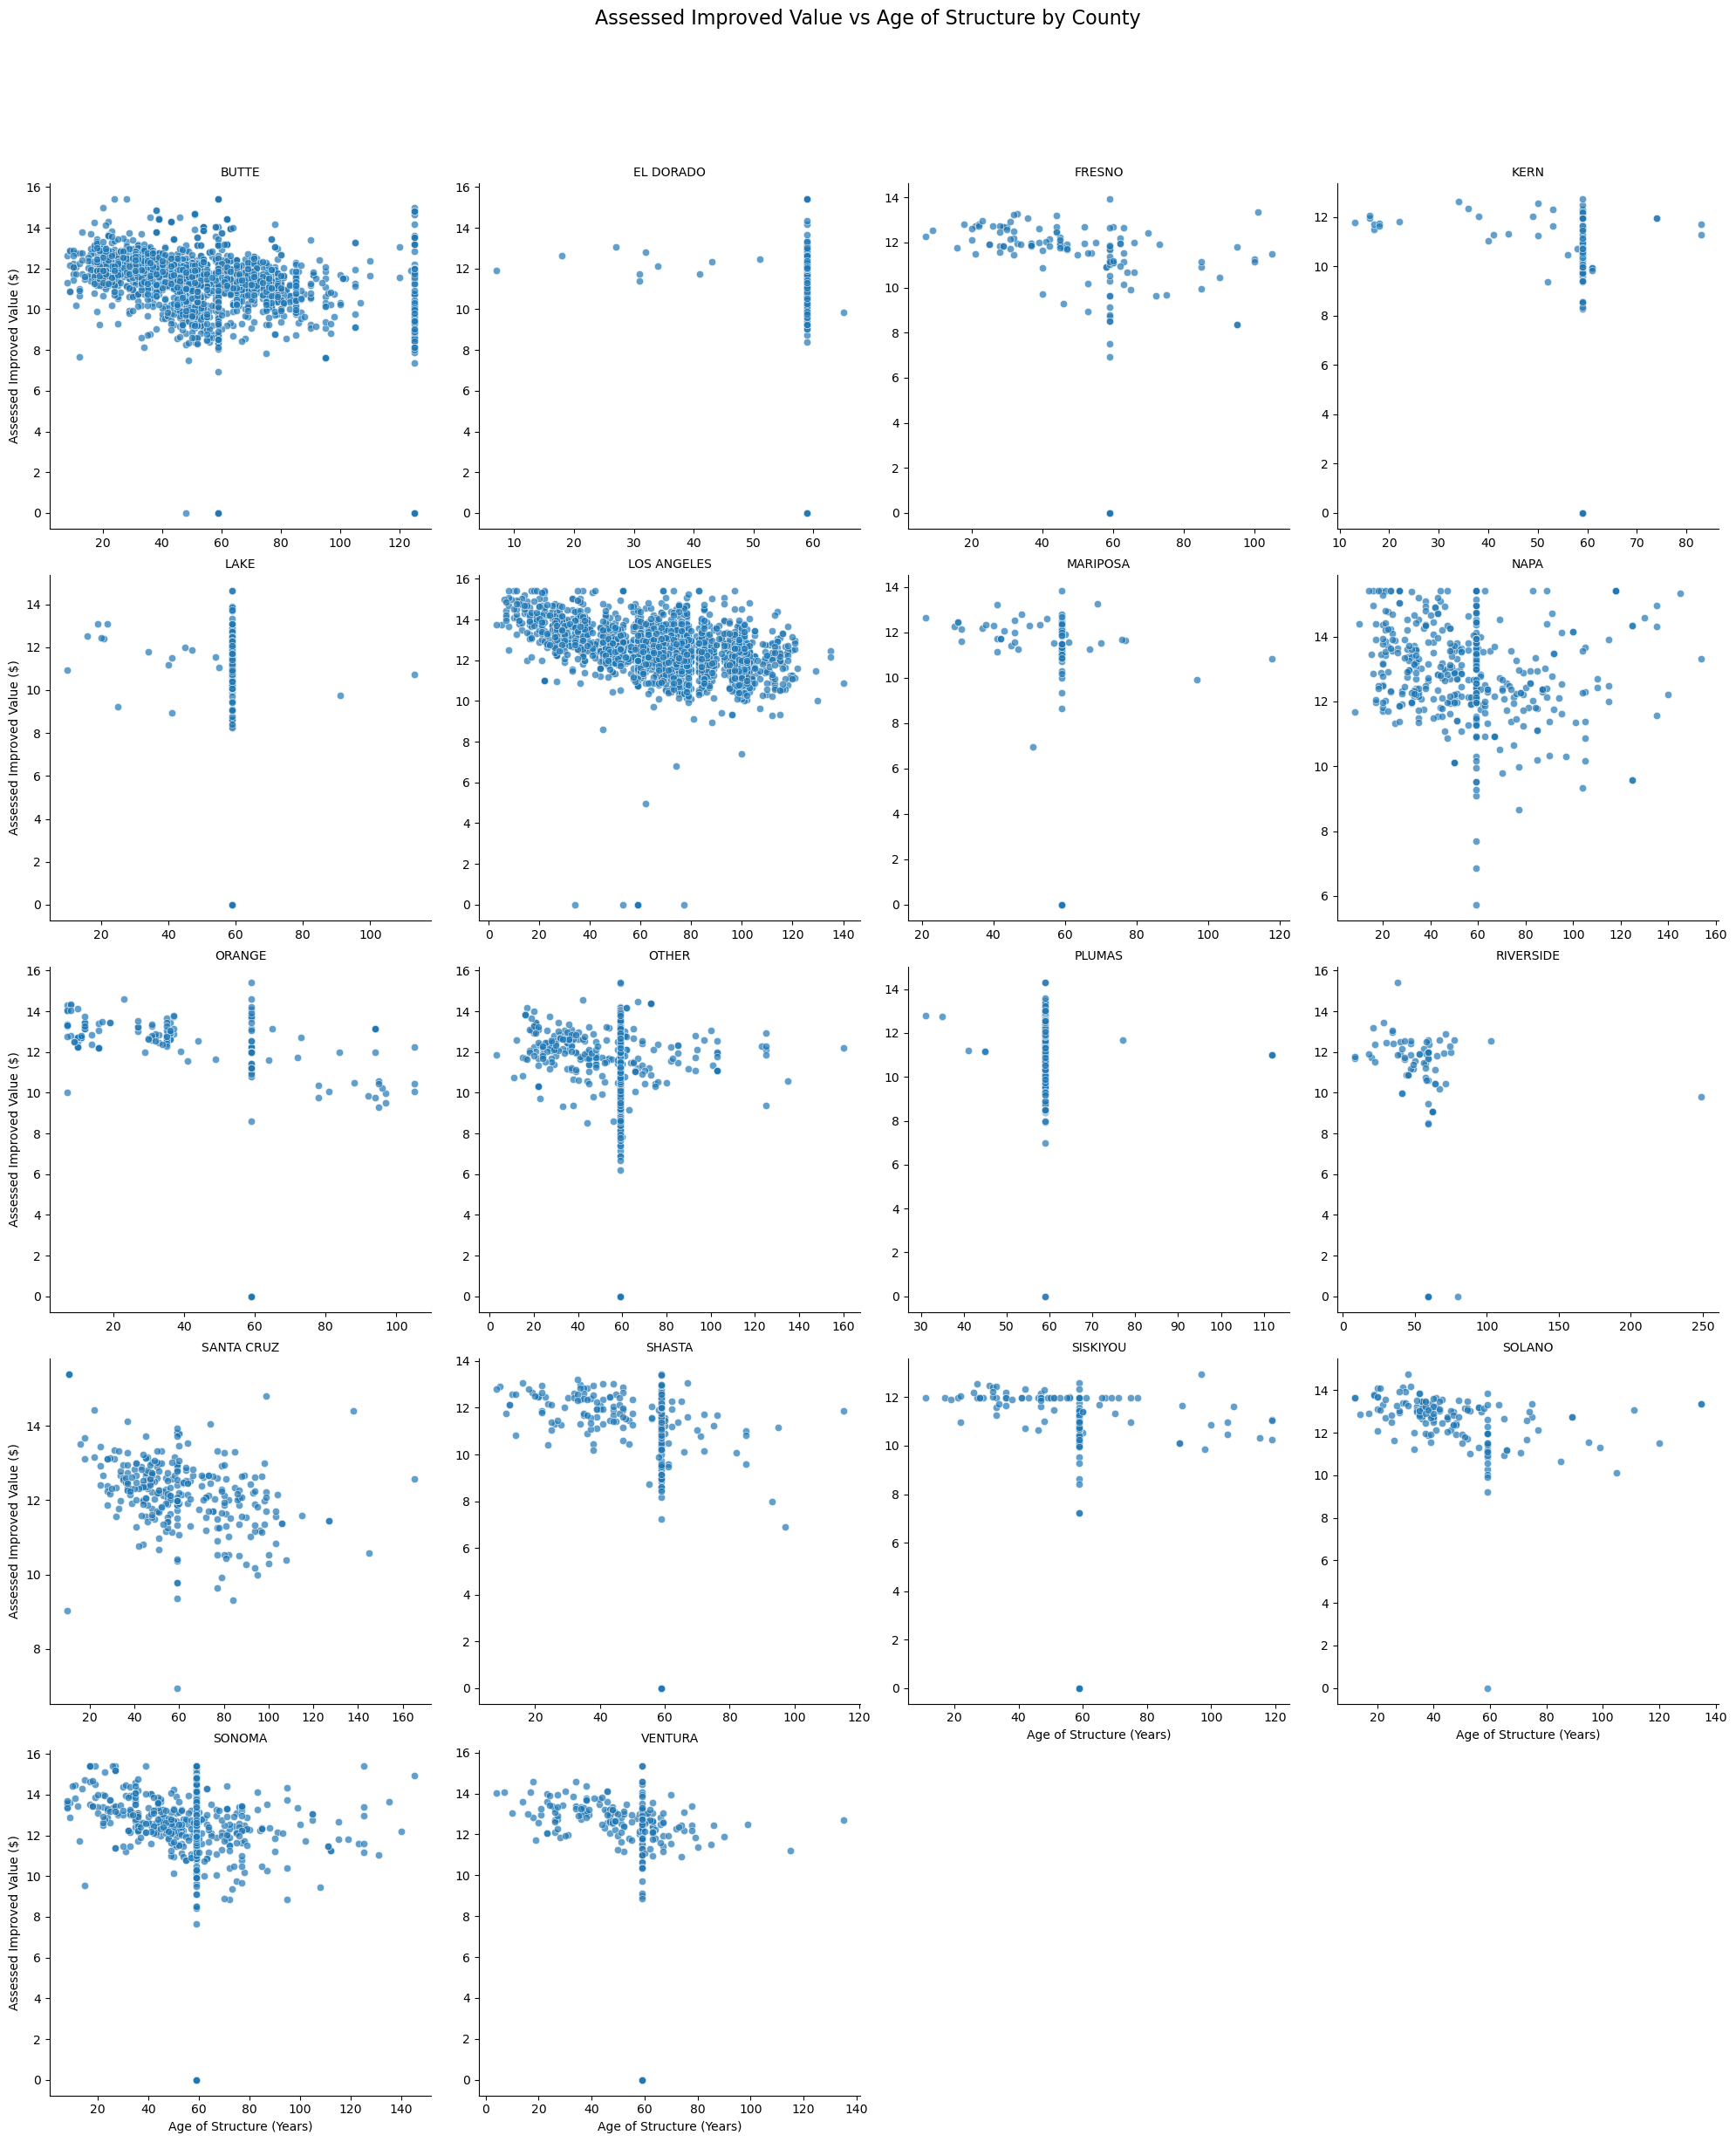

In [11]:
g = sns.FacetGrid(df, col="County", col_wrap=4, height=5, sharex=False, sharey=False)
g.map(sns.scatterplot, "AgeofStructure", "AssessedImprovedValue", alpha=0.7)
g.set_axis_labels('Age of Structure (Years)', 'Assessed Improved Value ($)')
g.set_titles(col_template="{col_name}", fontsize=14)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Assessed Improved Value vs Age of Structure by County', fontsize=16)

# Show the plot
plt.show()


##### **Observations:**
- The county-specific plots provide a more granular view, but the core finding remains the same
- It appears that age of structure, even within a specific county, is not a strong or consistent predictor of assessed improved value
- The above plots for counties highlight the importance of location, as we see variations in scatterplot patterns. These variations may be the result of market dynamics, property characteristics, or assessment practices

##### **Quantitative Assessment:**
- Will calculate the correlation coefficients between property age and assessed improved value for each county to quantify the strength and direction of linear relationships

In [12]:
correlation_by_county = df.groupby('County').apply(lambda x: x[['AgeofStructure', 'AssessedImprovedValue']].corr().iloc[0, 1])
correlation_by_county = correlation_by_county.reset_index(name='Correlation Coefficient')
print(correlation_by_county)


         County  Correlation Coefficient
0         BUTTE                -0.241843
1     EL DORADO                -0.046142
2        FRESNO                -0.360867
3          KERN                -0.162852
4          LAKE                -0.076692
5   LOS ANGELES                -0.203774
6      MARIPOSA                -0.148376
7          NAPA                -0.049651
8        ORANGE                -0.356683
9         OTHER                -0.115178
10       PLUMAS                -0.040976
11    RIVERSIDE                -0.159492
12   SANTA CRUZ                -0.331203
13       SHASTA                -0.256151
14     SISKIYOU                -0.157255
15       SOLANO                -0.326203
16       SONOMA                -0.203856
17      VENTURA                -0.201103


##### **Observations:**
- All of the correlation coefficients are negative, meaning that, on average, as Age of Structure increases, the Assessed Improved Value tends to decreases. This is likely due to depreciation of structure value over time, but older structures *might* be more vulnerable to wildfire damage, resulting in lower values for AssessedImprovedValue. This could be due to flammable materials or poor maintenance (dry rot, overgrown vegetation, etc.)
- The variations in strength of negative correlation between counties *could* potentially be linked to specific wildfire events. Counties with a history of more severe or frequent wildfires might exhibit a stronger negative age-value correlation, especially for older structures
- The magnitudes of the correlation coefficients generally represent weak to moderate linear relationships. As a result, age is not a primary factor for predicting property improved values

##### **Findings:**
Based on these findings, we can conclude that property valuation is complex and influenced by factors beyond age. The consistent negative correlation between AgeofStructure and AssessedImprovedValue aligns with the expectation of property depreciation, but natural disasters, such as wildfires, may be strengthening the observed negative correlation by disproportionately impacting older structures. While depreciation is the primary factor for the negative correlation between AgeofStructure and AssessedImprovedValue, wildfire damage may be an exacerbating factor.

We can perform further investigation to understand predictors of AssessedImprovedValue
Suggestions for further investigation:
- Use latitude and longitude to map AssessedImprovedValue and Age of structure, as there can be significant variations within counties. Look for clusters of high or low values
- Explore structural characteristics such as RoofConstruction, ExteriorSiding, and StructureType

#### Plot 2: ExteriorSiding vs. RoofConstruction (Categorical vs. Categorical Relationship)
- Determine whether there are common combinations or patterns between materials used for a building's roof and its exterior siding

In [13]:
roof_counts = df['RoofConstruction'].value_counts()
roof_counts

RoofConstruction
ASPHALT           4576
METAL             1517
UNKNOWN           1418
FIRE RESISTANT     960
TILE               793
OTHER              624
COMBUSTIBLE        112
Name: count, dtype: int64

In [14]:
exterior_counts = df['ExteriorSiding'].value_counts()
exterior_counts

ExteriorSiding
STUCCO BRICK CEMENT        2672
WOOD                       2200
UNKNOWN                    1746
COMBUSTIBLE                1637
FIRE/IGNITION RESISTANT    1189
OTHER                       556
Name: count, dtype: int64

In [15]:
#Contingency table to display frequencies for combination of two categorical features
contingency_table = pd.crosstab(df['RoofConstruction'], df['ExteriorSiding'])

#Calculate row proportions
row_proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

print(row_proportions)

ExteriorSiding    COMBUSTIBLE  FIRE/IGNITION RESISTANT     OTHER  \
RoofConstruction                                                   
ASPHALT              0.197990                 0.103147  0.024694   
COMBUSTIBLE          0.785714                 0.116071  0.000000   
FIRE RESISTANT       0.445833                 0.473958  0.000000   
METAL                0.101516                 0.097561  0.235992   
OTHER                0.041667                 0.017628  0.108974   
TILE                 0.016393                 0.073140  0.015132   
UNKNOWN              0.015515                 0.022567  0.003526   

ExteriorSiding    STUCCO BRICK CEMENT   UNKNOWN      WOOD  
RoofConstruction                                           
ASPHALT                      0.358392  0.015516  0.300262  
COMBUSTIBLE                  0.000000  0.098214  0.000000  
FIRE RESISTANT               0.000000  0.080208  0.000000  
METAL                        0.116678  0.025709  0.422544  
OTHER                      

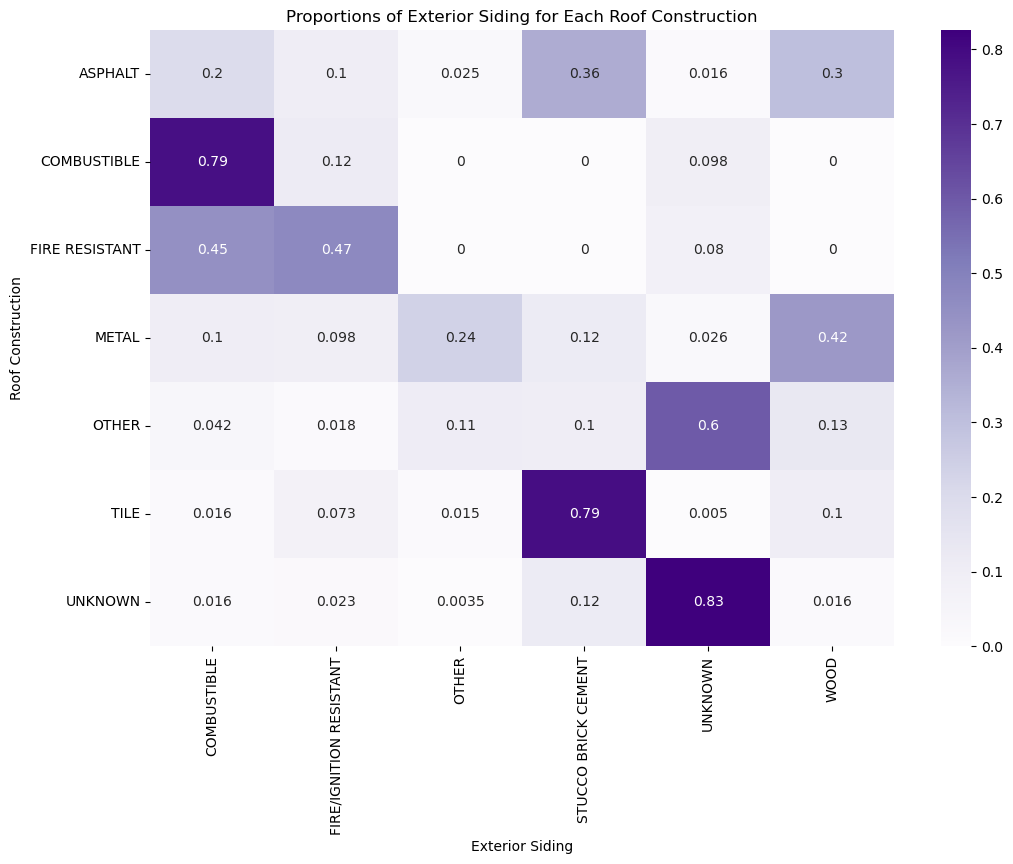

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(row_proportions, annot=True, cmap='Purples')
plt.title('Proportions of Exterior Siding for Each Roof Construction')
plt.xlabel('Exterior Siding')
plt.ylabel('Roof Construction')
plt.show()

**Observations:**
- A very high proportion of UNKNOWN roofs are associated with UNKNOWN exterior siding. This indicates a systemic pattern of missing information in both features, likely due to errors in data collection
- A high proportion of COMBUSTIBLE roofs are associate with COMBUSTIBLE exterior siding. This indicates a high correlation for combustible materials used for both roof and siding, which could be a predictor for damage due to wildfires
- A high proportion of TILE roofs are associated with STUCCO BRICK CEMENT siding, which likely reflects regional building styles or common construction practices

Will further investigate the relationship between RoofConstruction and ExteriorSiding by exploring patterns across counties

In [17]:
counties = df['County'].unique()

for county in counties:
    print(f"\n--- County: {county} ---")
    county_df = df[df['County'] == county]
    contingency_table = pd.crosstab(county_df['RoofConstruction'], county_df['ExteriorSiding'])
    row_proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    print(row_proportions)


--- County: SONOMA ---
ExteriorSiding    COMBUSTIBLE  FIRE/IGNITION RESISTANT     OTHER  \
RoofConstruction                                                   
ASPHALT              0.000000                 0.000000  0.037313   
COMBUSTIBLE          0.820513                 0.153846  0.000000   
FIRE RESISTANT       0.490909                 0.470707  0.000000   
METAL                0.000000                 0.000000  0.222222   
OTHER                0.050000                 0.050000  0.450000   
TILE                 0.000000                 0.000000  0.055556   
UNKNOWN              0.016484                 0.005495  0.000000   

ExteriorSiding    STUCCO BRICK CEMENT   UNKNOWN      WOOD  
RoofConstruction                                           
ASPHALT                      0.298507  0.014925  0.649254  
COMBUSTIBLE                  0.000000  0.025641  0.000000  
FIRE RESISTANT               0.000000  0.038384  0.000000  
METAL                        0.155556  0.044444  0.577778  
OTH


--- County: SONOMA ---


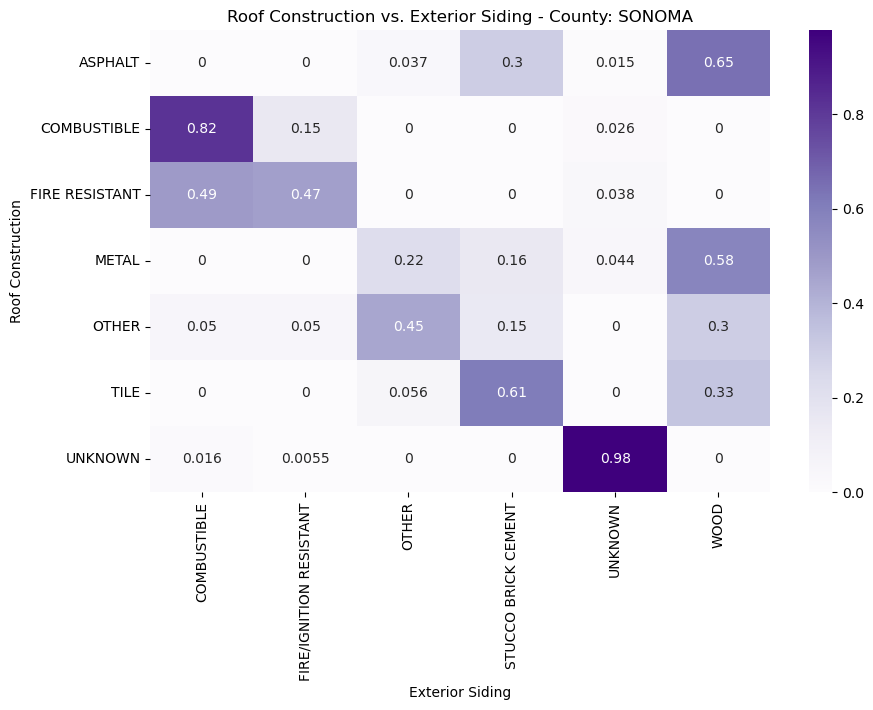


--- County: LAKE ---


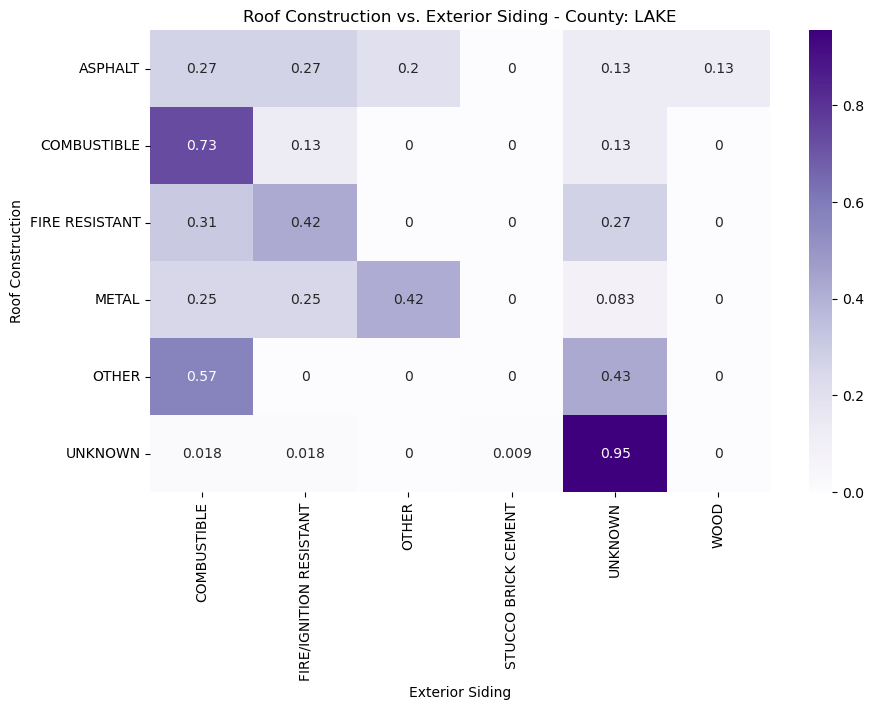


--- County: OTHER ---


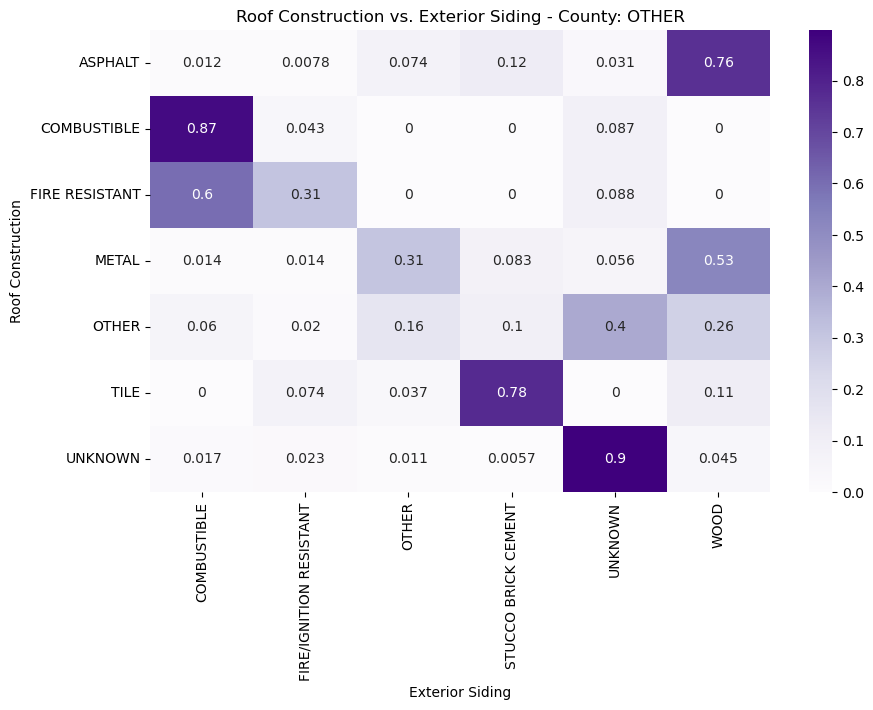


--- County: EL DORADO ---


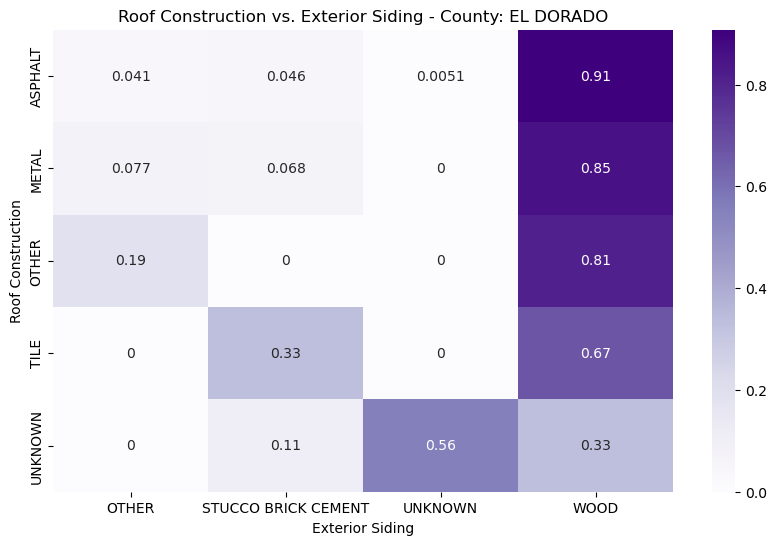


--- County: LOS ANGELES ---


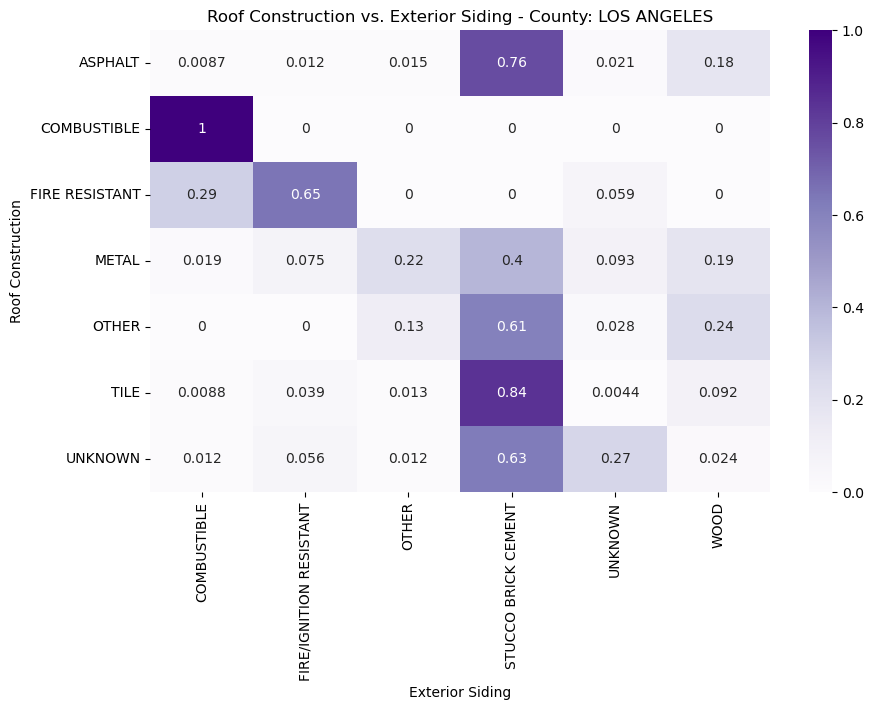


--- County: SANTA CRUZ ---


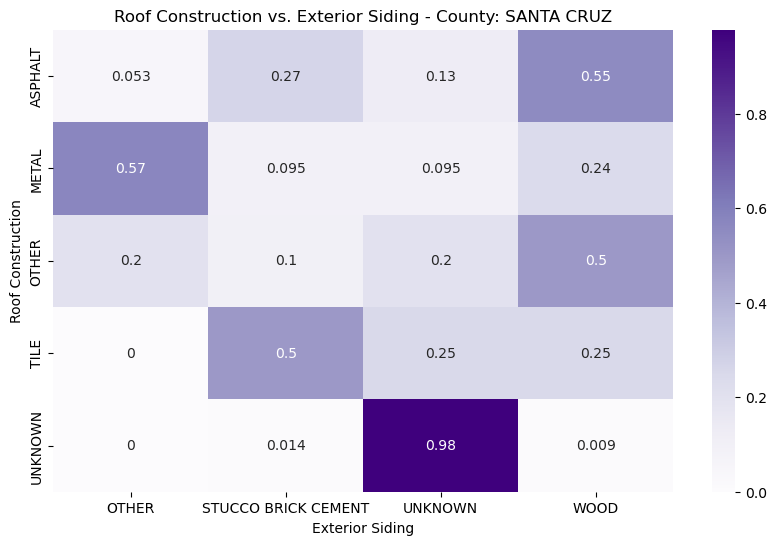


--- County: FRESNO ---


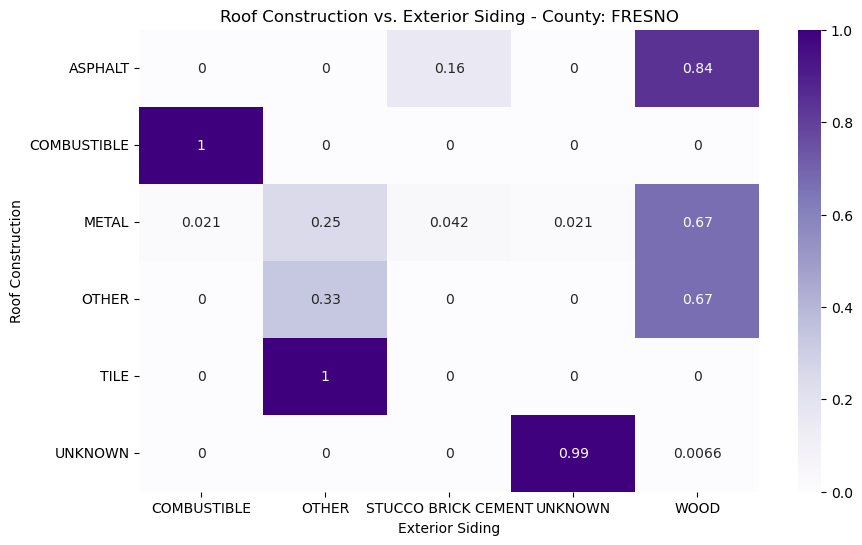


--- County: BUTTE ---


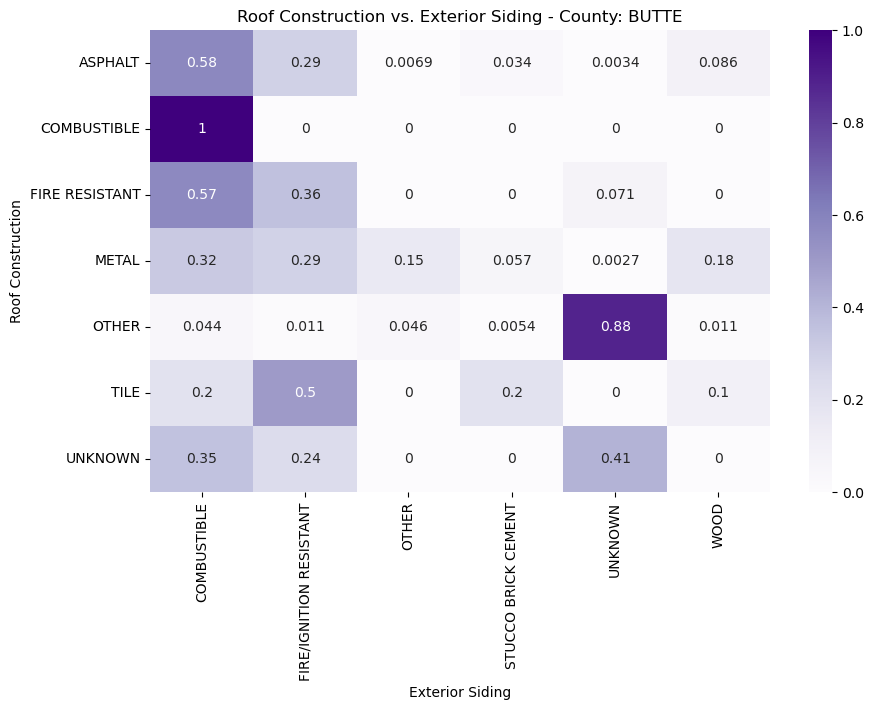


--- County: RIVERSIDE ---


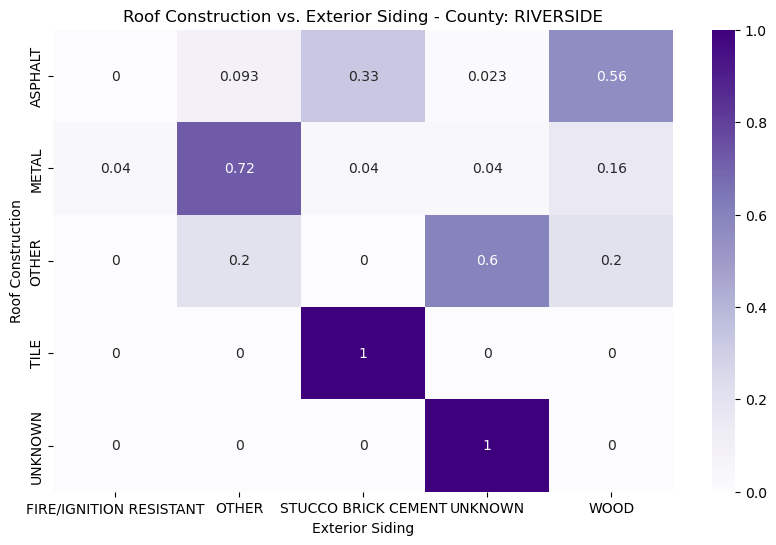


--- County: NAPA ---


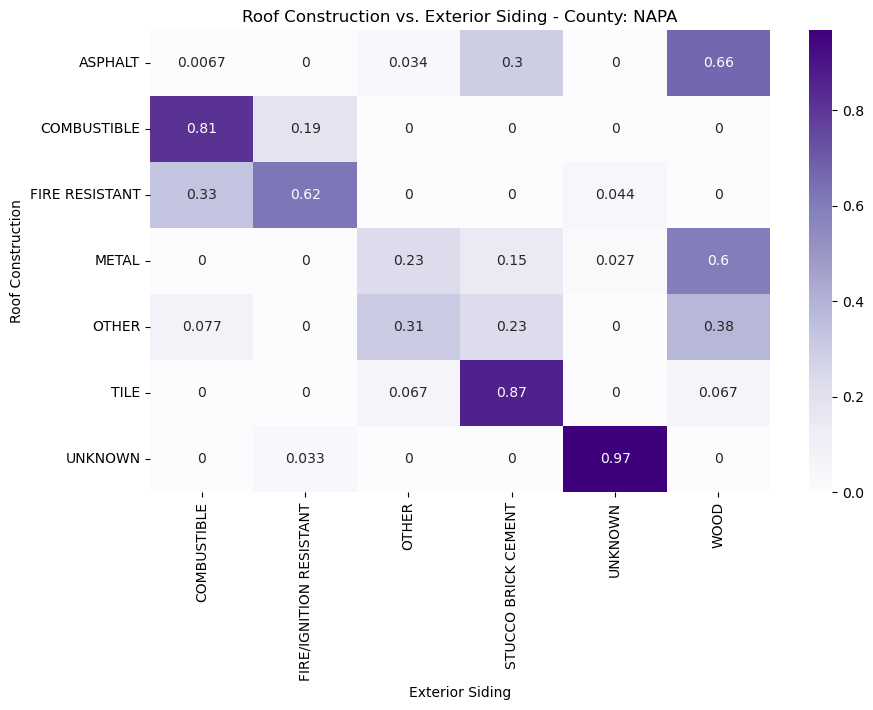


--- County: VENTURA ---


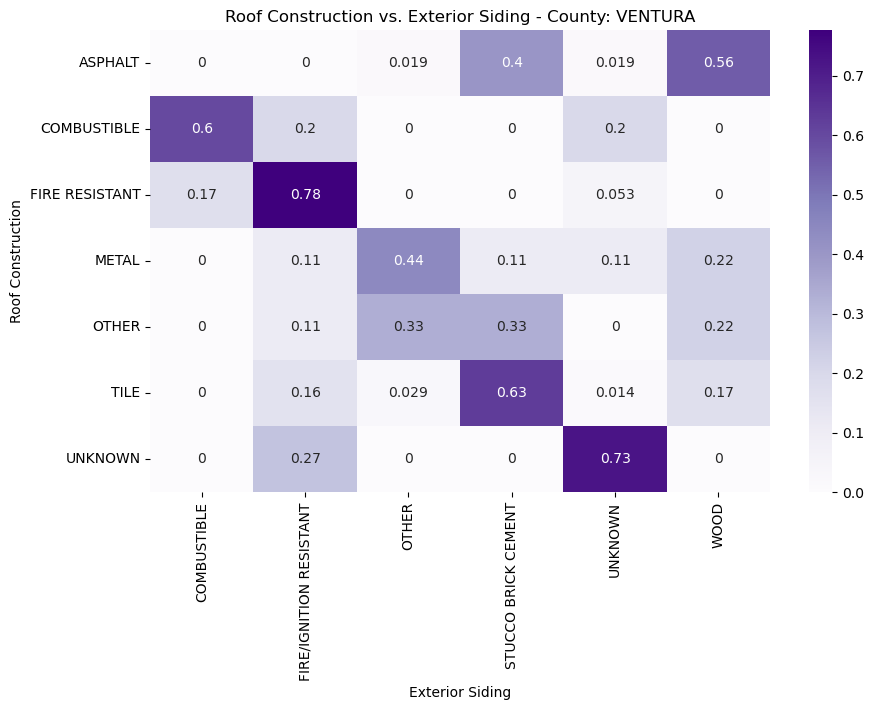


--- County: PLUMAS ---


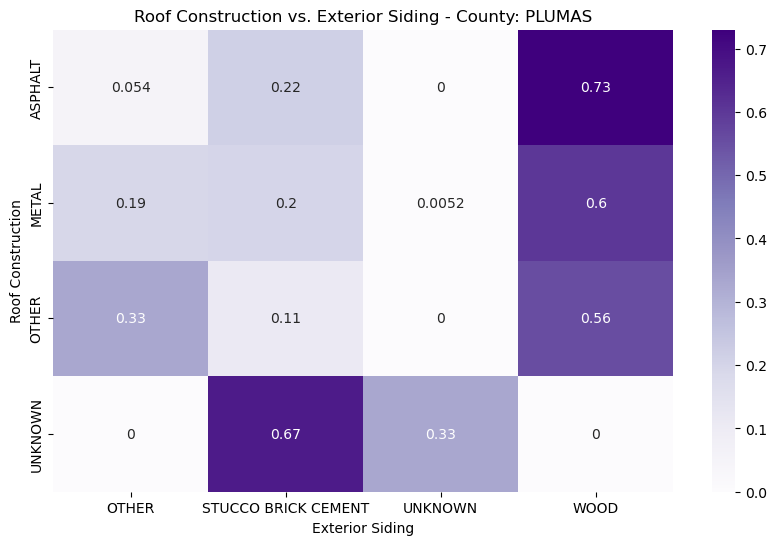


--- County: KERN ---


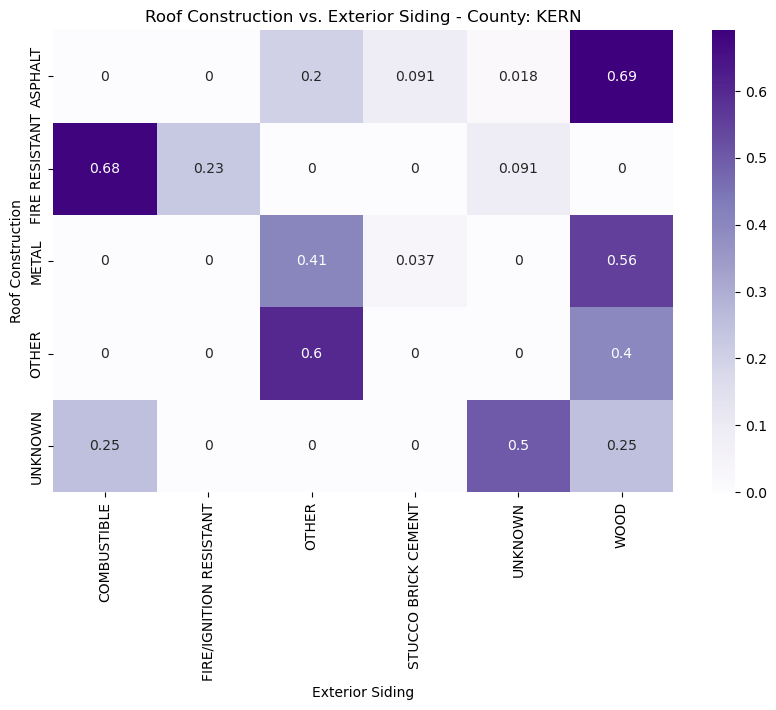


--- County: SOLANO ---


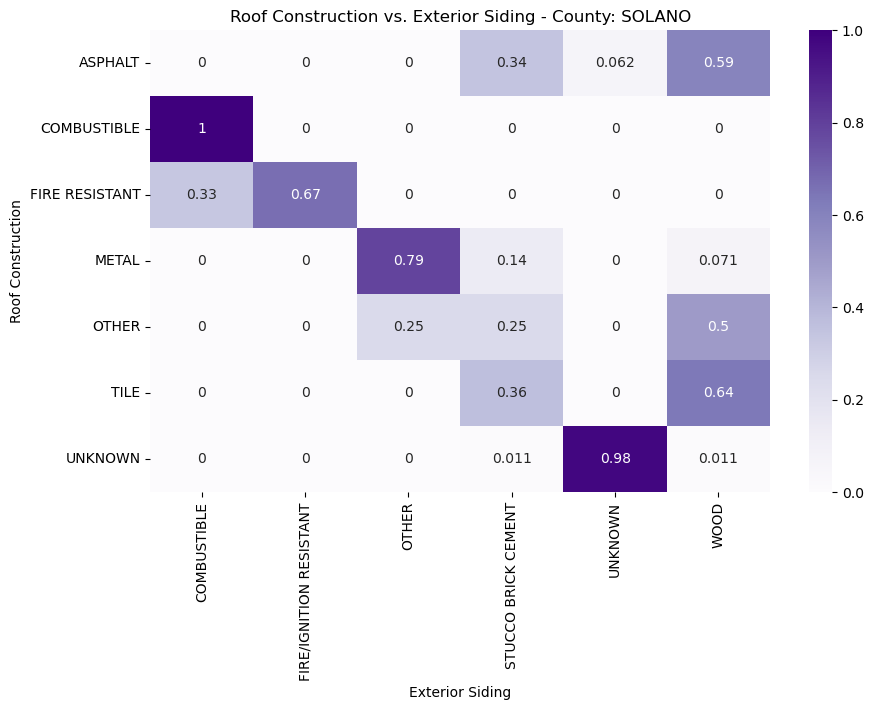


--- County: SISKIYOU ---


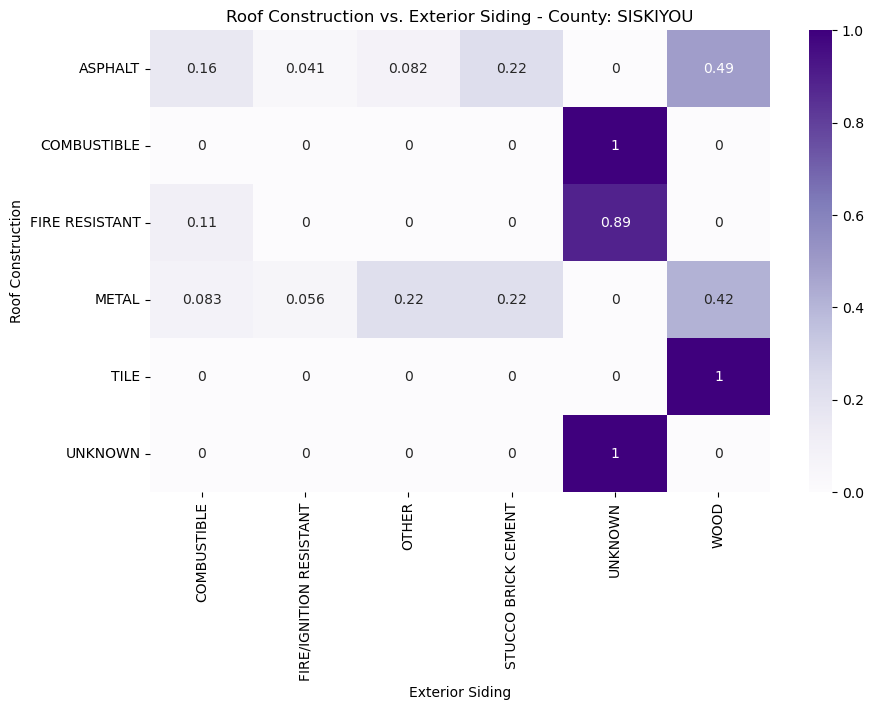


--- County: SHASTA ---


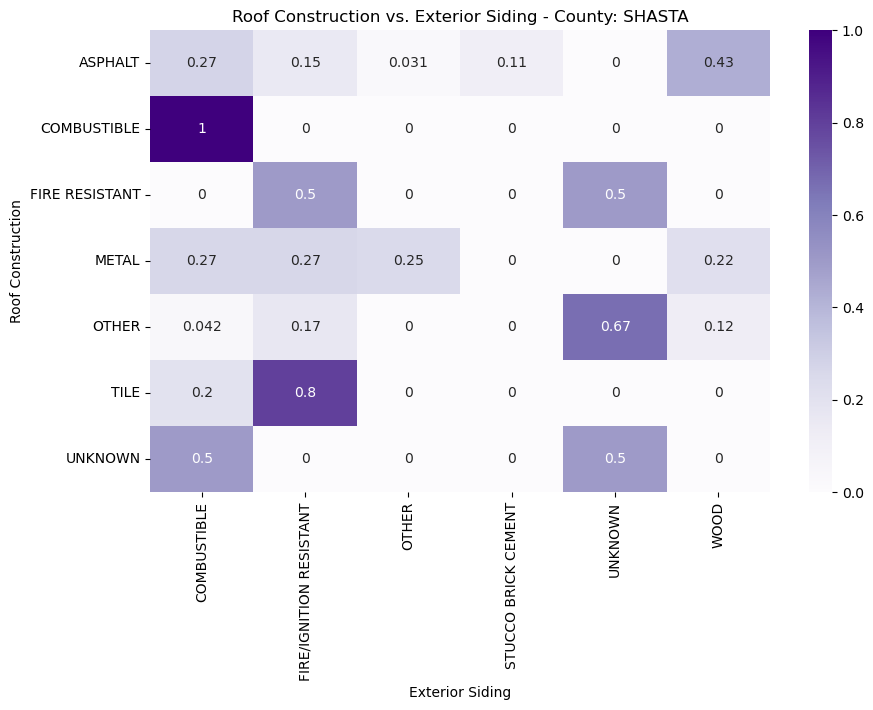


--- County: ORANGE ---


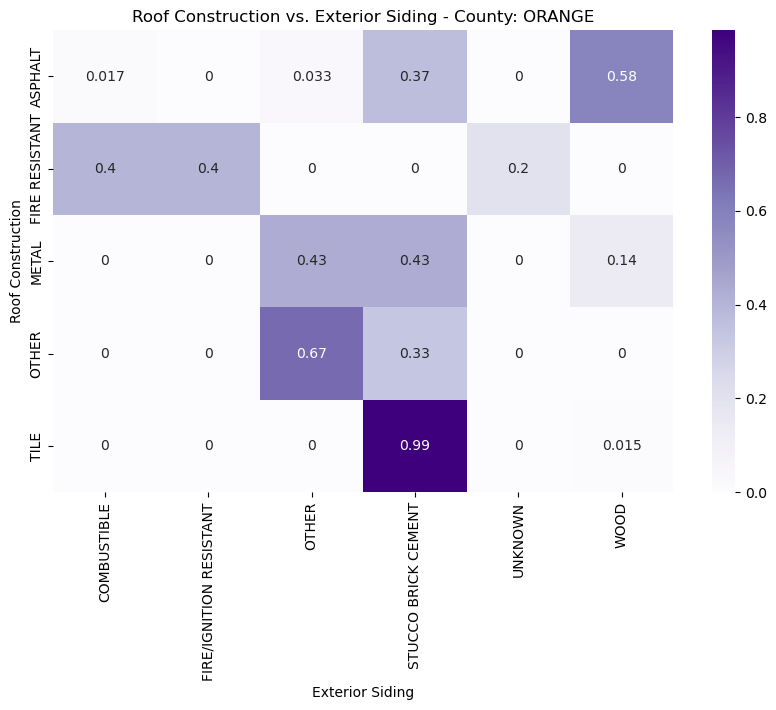


--- County: MARIPOSA ---


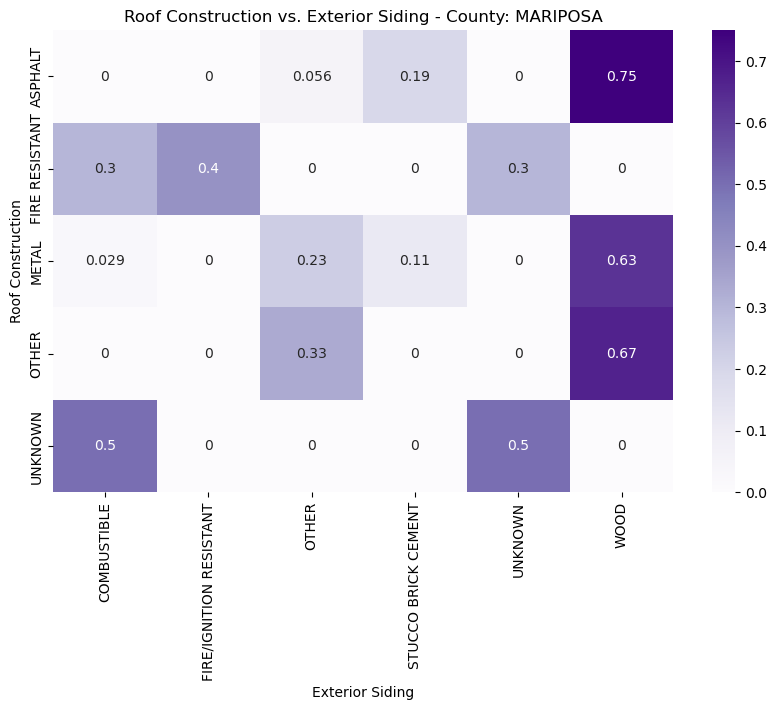

In [18]:
counties = df['County'].unique()

for county in counties:
    print(f"\n--- County: {county} ---")
    county_df = df[df['County'] == county]
    contingency_table = pd.crosstab(county_df['RoofConstruction'], county_df['ExteriorSiding'])
    row_proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    
    plt.figure(figsize=(10,6))
    sns.heatmap(row_proportions, annot=True, cmap='Purples')
    plt.title(f'Roof Construction vs. Exterior Siding - County: {county}')
    plt.xlabel('Exterior Siding')
    plt.ylabel('Roof Construction')
    plt.show()

**Observations:**
- Several counties (e.g., FRESNO, RIVERSIDE, SANTA CRUZ, and SISKIYOU) have significant proportions of UNKNOWN roof and siding types. This indicates potential data inconsistencies or missing information
- There are regional variations in material preferences
    - ORANGE and LOS ANGELES counties show a strong preference for TILE roofs and STUCCO BRICK CEMENT siding. This is consistent with architecture style of homes in southern California


Will now investigate whether RoofConstruction and ExteriorSiding have relationships with the target variable Damage

In [19]:
#Contingency table: RoofConstruction vs. Damage
roof_damage_table = pd.crosstab(df['RoofConstruction'], df['Damage'])
# Proportions for RoofConstruction vs. Damage
roof_damage_proportions = roof_damage_table.div(roof_damage_table.sum(axis=1), axis=0)
#Contingency table: ExteriorSiding vs. Damage
siding_damage_table = pd.crosstab(df['ExteriorSiding'], df['Damage'])
# Proportions for ExteriorSiding vs. Damage
siding_damage_proportions = siding_damage_table.div(siding_damage_table.sum(axis=1), axis=0)

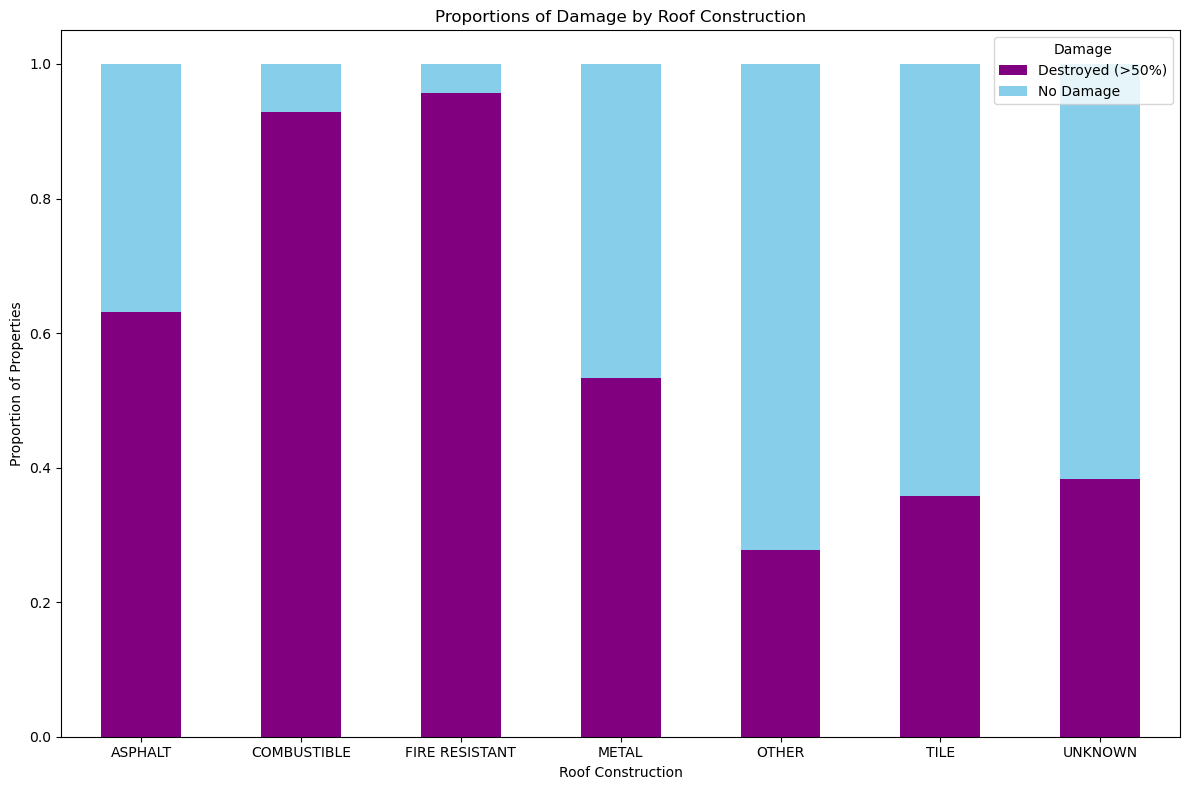

In [20]:
colors = ['purple', 'skyblue']
roof_damage_proportions.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
plt.title('Proportions of Damage by Roof Construction')
plt.xlabel('Roof Construction')
plt.ylabel('Proportion of Properties')
plt.legend(title='Damage')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

**Observations:**
- Surprisingly, structures with FIRE RESISTANT roofs show the highest proportion of damage by wildfires. We should investigate this further
- As expected, COMBUSTIBLE roofs show a high proportion of damage. These roofs are more vulnerable to wildfire events
- There are high proportions of NO DAMAGE for METAL and TILE roofs, indicating that these roof types are likely more resistant to fire damage

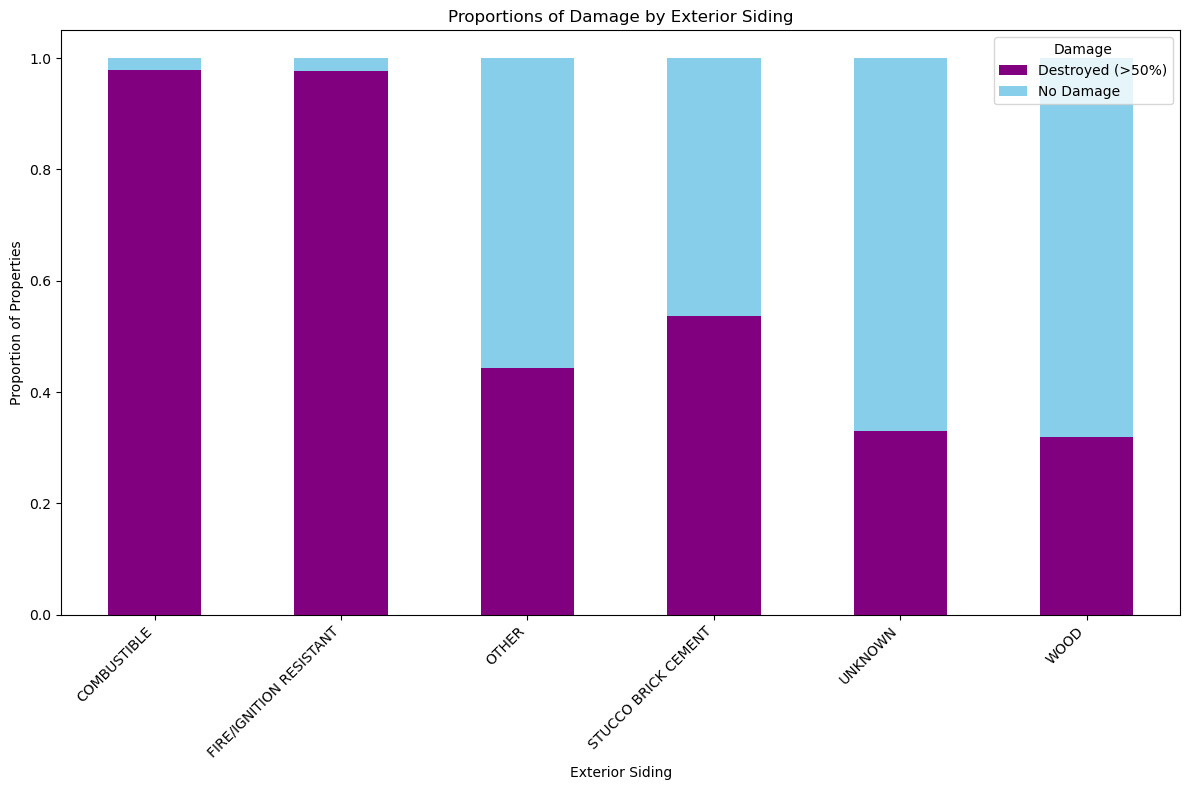

In [21]:
colors = ['purple', 'skyblue']
siding_damage_proportions.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
plt.title('Proportions of Damage by Exterior Siding')
plt.xlabel('Exterior Siding')
plt.ylabel('Proportion of Properties')
plt.legend(title='Damage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observations:**
- Surprisingly, structures with FIRE/IGNITION RESISTANT roofs show the highest proportion of damage by wildfires. We should investigate this further
- As expected, COMBUSTIBLE exterior siding shows a high proportion of damage, indicating that this siding type is highly vulnerable to wildfire events


##### **Findings:**
**1. Relationship Between RoofConstruction and ExteriorSiding**
- There appears to be a relationship between roof construction and exterior siding, as patterns appeared during the analysis. These patterns suggest preferences or common practices in structure construction
    - Common Combinations: COMBUSTIBLE roofs are highly associated with COMBUSTIBLE siding, indicating potential vulernability for structures. TILE roofs are commonly associated with STUCCO BRICK CEMENT, which indicates a common architecture style and regional variation
    - Rare Combinations: Some combinations are absent from the data set, such as COMBUSTIBLE roofs with STUCCO BRICK CEMENT siding. This indicates that certain combinations are uncommon construction practices or potential data anomalies
    - UNKNOWN with UNKNOWN: UNKNOWN roofs are strongly associated with UNKNOWN siding, likely reflecting systemic lack of information for certain properties

- There are some regional variations in the relationship between RoofConstruction and ExteriorSiding. This may be due to certain styles being more common in specific areas for reasons such as climate, local materials, or architectural styles. Latitude and longitude can also be used to visualize these patterns. 

**2. Relationship Between RoofConstruction/Damage and ExteriorSiding/Damage**
- The analysis of roof construction and exterior siding in relation to damage reveals significant disparities in damage, indicating that material choices likely play a pivotal role in a structure's resilience to wildfire damage
    - High-Risk Materials: COMBUSTIBLE and FIRE/IGNITION RESISTANT siding exhibit high proportions of damage. COMBUSTIBLE and FIRE RESISTANT roofs also show a high proportion of damage
    - Protective Materials: METAL and TILE roofs demonstrate high proportions of no damage than other roof materials
    - Data Gaps: The UNKNOWN categories for both roof and siding show mixed results, highlighting the need for improved data collection to draw definitive conclusion
    - Anomalies: The FIRE RESISTANT roof showing high damage is an anomaly that requires further investigation